Enerji modellerinde teklifler saat 12.00'a kadar, bir sonraki günün 24 saati için veriliyor.

Bu sebeple saat 12.00'dan itibaren, 12 saat gecikmeyle gelecek 24 saati tahmin eden bir model kurmaya çalıştım.

Başlangıç [12:] şeklinde oldu, tahmin edilen değer ise [24:]'ten itibaren oldu.

Saat [12:]'dan önceki son 24 saati aldım.

# 1- PREPROCESSING

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Wind speed data will be extracted from files.
document = pd.read_excel("Gallipoli.xlsx")
document.head()

,DateTime,Temperature,Sunshine Duration,Shortwave Radiation,Relative Humidity,Mean Sea Level Pressure,Soil Temperature,Soil Moisture,Wind Speed,Wind Direction,Day,Month,Year,Hour
0,2008-01-01 03:00:00,-0.1,0,0.0,92,1019.2,5.9,0.212,0.0,180.00,1,1,2008,3
1,2008-01-01 04:00:00,2.5,0,0.0,92,1018.2,5.4,0.212,22.7,43.07,1,1,2008,4
2,2008-01-01 05:00:00,2.9,0,0.0,95,1017.1,5.1,0.212,25.8,54.09,1,1,2008,5
3,2008-01-01 06:00:00,3.9,0,0.0,95,1017.4,4.9,0.212,25.8,59.86,1,1,2008,6
4,2008-01-01 07:00:00,4.9,0,0.0,93,1016.4,5.1,0.211,26.7,61.02,1,1,2008,7


In [3]:
temperature_orj = np.array(document["Temperature"])
temperature_orj = temperature_orj.reshape([temperature_orj.shape[0], 1])
sunshine_orj = np.array(document["Sunshine Duration"]).reshape([temperature_orj.shape[0],1])
radiation_orj = np.array(document["Shortwave Radiation"]).reshape([temperature_orj.shape[0],1])
humidity_orj = np.array(document["Relative Humidity"]).reshape([temperature_orj.shape[0],1])
pressure_orj = np.array(document["Mean Sea Level Pressure"]).reshape([temperature_orj.shape[0],1])
soil_temp_orj = np.array(document["Soil Temperature"]).reshape([temperature_orj.shape[0],1])
soil_moist_orj = np.array(document["Soil Moisture"]).reshape([temperature_orj.shape[0],1])
wind_speed_orj = np.array(document["Wind Speed"]).reshape([temperature_orj.shape[0],1])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

temperature_train = temperature_orj[:3653*24]
sunshine_train = sunshine_orj[:3653*24]
radiation_train = radiation_orj[:3653*24]
humidity_train = humidity_orj[:3653*24]
pressure_train = pressure_orj[:3653*24]
soil_temp_train = soil_temp_orj[:3653*24]
soil_moist_train = soil_moist_orj[:3653*24]
wind_speed_train = wind_speed_orj[:3653*24]

temperature_test = temperature_orj[3653*24:]
sunshine_test = sunshine_orj[3653*24:]
radiation_test = radiation_orj[3653*24:]
humidity_test = humidity_orj[3653*24:]
pressure_test = pressure_orj[3653*24:]
soil_temp_test = soil_temp_orj[3653*24:]
soil_moist_test = soil_moist_orj[3653*24:]
wind_speed_test = wind_speed_orj[3653*24:]

temperature_train = scaler.fit_transform(temperature_train)
temperature_test = scaler.transform(temperature_test)

sunshine_train = scaler.fit_transform(sunshine_train)
sunshine_test = scaler.transform(sunshine_test)

radiation_train = scaler.fit_transform(radiation_train)
radiation_test = scaler.transform(radiation_test)

humidity_train = scaler.fit_transform(humidity_train)
humidity_test = scaler.transform(humidity_test)

pressure_train = scaler.fit_transform(pressure_train)
pressure_test = scaler.transform(pressure_test)

soil_temp_train = scaler.fit_transform(soil_temp_train)
soil_temp_test = scaler.transform(soil_temp_test)

soil_moist_train = scaler.fit_transform(soil_moist_orj)
soil_moist_test = scaler.transform(soil_moist_test)

wind_speed_train = scaler.fit_transform(wind_speed_train)
wind_speed_test = scaler.transform(wind_speed_test)

#2 - TIME SERIES FOR WIND SPEED

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
wind_speed_trainP, wind_speed_trainF = create_dataset(wind_speed_train, look_back=24)
wind_speed_testP, wind_speed_testF = create_dataset(wind_speed_test, look_back=24)
wind_speed_trainF = wind_speed_trainF.reshape(wind_speed_trainF.size, 1)
wind_speed_testF = wind_speed_testF.reshape(wind_speed_testF.size, 1)

wind_speed_trainP = np.reshape(wind_speed_trainP, (wind_speed_trainP.shape[0], 1, wind_speed_trainP.shape[1]))
wind_speed_trainF = np.reshape(wind_speed_trainF, (wind_speed_trainF.shape[0], 1, wind_speed_trainF.shape[1]))

wind_speed_testP = np.reshape(wind_speed_testP, (wind_speed_testP.shape[0], 1, wind_speed_testP.shape[1]))
wind_speed_testF = np.reshape(wind_speed_testF, (wind_speed_testF.shape[0], 1, wind_speed_testF.shape[1]))

In [5]:

model = keras.Sequential()
model.add(LSTM(64, activation="sigmoid", return_sequences=True, input_shape=(1,24)))
model.add(Bidirectional(LSTM(64, activation="sigmoid",  return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation="sigmoid",  return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
model.fit(wind_speed_trainP, wind_speed_trainF, epochs=5, batch_size=24, verbose=2)

Epoch 1/5
3652/3652 - 7s - loss: 0.1006 - mae: 0.1968 - mape: 89.4127 - 7s/epoch - 2ms/step
Epoch 2/5
3652/3652 - 6s - loss: 0.0556 - mae: 0.1552 - mape: 77.2504 - 6s/epoch - 2ms/step
Epoch 3/5
3652/3652 - 6s - loss: 0.0536 - mae: 0.1522 - mape: 76.2229 - 6s/epoch - 2ms/step
Epoch 4/5
3652/3652 - 6s - loss: 0.0529 - mae: 0.1513 - mape: 75.5075 - 6s/epoch - 2ms/step
Epoch 5/5
3652/3652 - 6s - loss: 0.0523 - mae: 0.1505 - mape: 74.9142 - 6s/epoch - 2ms/step


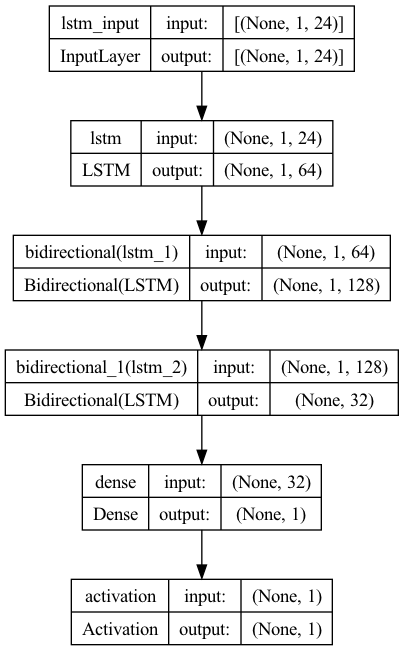

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

2739/2739 [==============================] - 2s 539us/step
0.9749335238241135
0.9492515159317534
0.7055615949369882


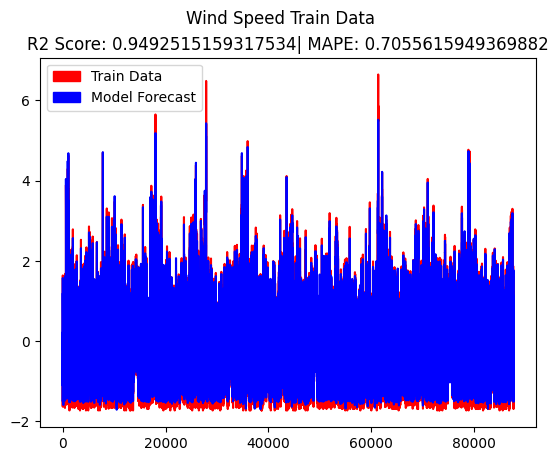

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

prediction2 = model.predict(wind_speed_trainP)
wind_speed_trainF = wind_speed_trainF.reshape(wind_speed_trainF.size, 1)
prediction2 = prediction2.reshape(prediction2.size, 1)
overall = pd.concat([pd.DataFrame(wind_speed_trainF), pd.DataFrame(prediction2)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))
print(r2_score(wind_speed_trainF, prediction2))
print(mean_absolute_percentage_error(wind_speed_trainF, prediction2))
title1 = "R2 Score: "+str(r2_score(wind_speed_trainF, prediction2))+"| MAPE: "+str(mean_absolute_percentage_error(wind_speed_trainF, prediction2))

plt.plot(np.linspace(0, prediction2.shape[0], prediction2.shape[0]), wind_speed_trainF, color="r")
plt.plot(np.linspace(0,prediction2.shape[0], prediction2.shape[0]), prediction2, color="b")
plt.suptitle("Wind Speed Train Data")
plt.title(title1)
red_patch = mpatches.Patch(color='red', label='Train Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

1095/1095 [==============================] - 1s 529us/step
0.9491383848554897
0.974819859946357


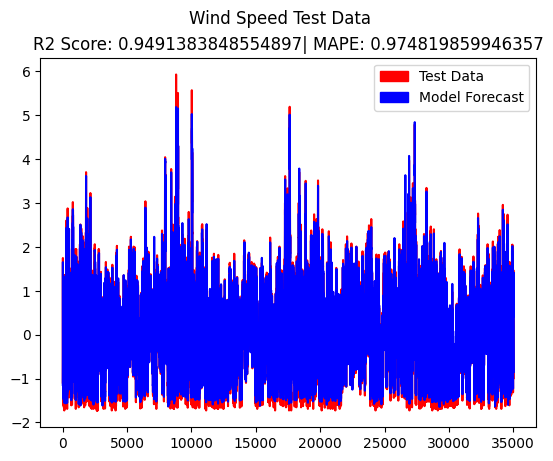

In [8]:
prediction3 = model.predict(wind_speed_testP)
wind_speed_testF = wind_speed_testF.reshape(wind_speed_testF.size, 1)
prediction3 = prediction3.reshape(prediction3.size, 1)

m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(wind_speed_testF, prediction3)
print(r2_score(wind_speed_testF, prediction3))

overall = pd.concat([pd.DataFrame(wind_speed_testF), pd.DataFrame(prediction3)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))
title2 = "R2 Score: "+str(r2_score(wind_speed_testF, prediction3))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, prediction3.shape[0], prediction3.shape[0]), wind_speed_testF, color="r")
plt.plot(np.linspace(0,prediction3.shape[0], prediction3.shape[0]), prediction3, color="b")
plt.suptitle("Wind Speed Test Data")
plt.title(title2)
red_patch = mpatches.Patch(color='red', label='Test Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

#3- TEMPERATURE TIME SERIES



In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

temperature_train, temperature_trainF = create_dataset(temperature_train, look_back=24)
temperature_test, temperature_testF = create_dataset(temperature_test, look_back=24)
temperature_trainF = temperature_trainF.reshape(temperature_trainF.size, 1)
temperature_testF = temperature_testF.reshape(temperature_testF.size, 1)

temperature_train = np.reshape(temperature_train, (temperature_train.shape[0], 1, temperature_train.shape[1]))
temperature_trainF = np.reshape(temperature_trainF, (temperature_trainF.shape[0], 1, temperature_trainF.shape[1]))

temperature_test = np.reshape(temperature_test, (temperature_test.shape[0], 1, temperature_test.shape[1]))
temperature_testF = np.reshape(temperature_testF, (temperature_testF.shape[0], 1, temperature_testF.shape[1]))

model = keras.Sequential()
model.add(LSTM(64, activation="sigmoid", return_sequences=True, input_shape=(1,24)))
model.add(Bidirectional(LSTM(64, activation="sigmoid",  return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation="sigmoid",  return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
model.fit(temperature_train, temperature_trainF, epochs=5, batch_size=24, verbose=2)

Epoch 1/5
3652/3652 - 8s - loss: 0.0362 - mae: 0.1097 - mape: 83.9984 - 8s/epoch - 2ms/step
Epoch 2/5
3652/3652 - 6s - loss: 0.0091 - mae: 0.0687 - mape: 58.0308 - 6s/epoch - 2ms/step
Epoch 3/5
3652/3652 - 6s - loss: 0.0082 - mae: 0.0647 - mape: 53.7437 - 6s/epoch - 2ms/step
Epoch 4/5
3652/3652 - 6s - loss: 0.0078 - mae: 0.0627 - mape: 52.9932 - 6s/epoch - 2ms/step
Epoch 5/5
3652/3652 - 6s - loss: 0.0076 - mae: 0.0616 - mape: 51.4604 - 6s/epoch - 2ms/step


2739/2739 [==============================] - 2s 525us/step
0.9966999089661835


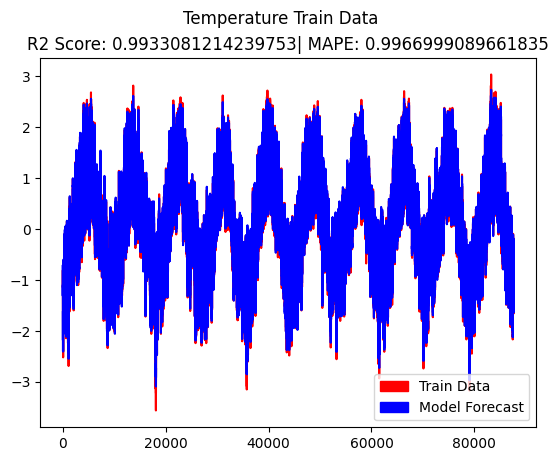

0.9933081214239753
1095/1095 [==============================] - 1s 495us/step
0.996615934049668
0.9931503814205709


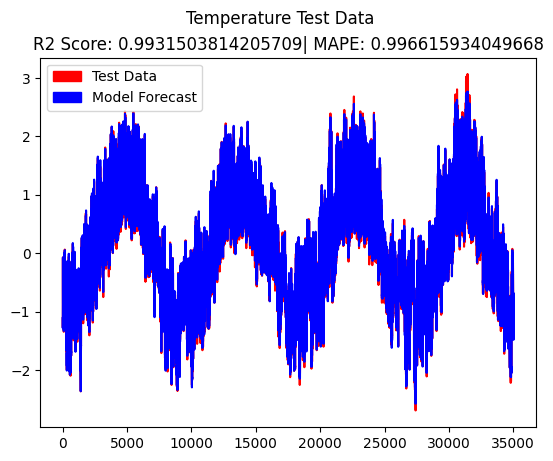

In [10]:
predictiontemp = model.predict(temperature_train)
temperature_trainF = temperature_trainF.reshape(temperature_trainF.size, 1)
predictiontemp = predictiontemp.reshape(predictiontemp.size, 1)

overall = pd.concat([pd.DataFrame(temperature_trainF), pd.DataFrame(predictiontemp)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, predictiontemp.shape[0], predictiontemp.shape[0]), temperature_trainF, color="r")
plt.plot(np.linspace(0,predictiontemp.shape[0], predictiontemp.shape[0]), predictiontemp, color="b")
title3 = "R2 Score: "+str(r2_score(temperature_trainF, predictiontemp))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Temperature Train Data")
plt.title(title3)
red_patch = mpatches.Patch(color='red', label='Train Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

print(r2_score(temperature_trainF, predictiontemp))

predictiontemp2 = model.predict(temperature_test)
temperature_testF = temperature_testF.reshape(temperature_testF.size, 1)
predictiontemp2 = predictiontemp2.reshape(predictiontemp2.size, 1)

overall = pd.concat([pd.DataFrame(temperature_testF), pd.DataFrame(predictiontemp2)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))
print(r2_score(temperature_testF, predictiontemp2))

plt.plot(np.linspace(0, predictiontemp2.shape[0], predictiontemp2.shape[0]), temperature_testF, color="r")
plt.plot(np.linspace(0,predictiontemp2.shape[0], predictiontemp2.shape[0]), predictiontemp2, color="b")
title4 = "R2 Score: "+str(r2_score(temperature_testF, predictiontemp2))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Temperature Test Data")
plt.title(title4)
red_patch = mpatches.Patch(color='red', label='Test Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

#4- PRESSURE TIME SERIES

In [11]:
pressure_train, pressure_trainF = create_dataset(pressure_train, look_back=24)
pressure_test, pressure_testF = create_dataset(pressure_test, look_back=24)
pressure_trainF = pressure_trainF.reshape(pressure_trainF.size, 1)
pressure_testF = pressure_testF.reshape(pressure_testF.size, 1)

pressure_train = np.reshape(pressure_train, (pressure_train.shape[0], 1, pressure_train.shape[1]))
pressure_trainF = np.reshape(pressure_trainF, (pressure_trainF.shape[0], 1, pressure_trainF.shape[1]))

pressure_test = np.reshape(pressure_test, (pressure_test.shape[0], 1, pressure_test.shape[1]))
pressure_testF = np.reshape(pressure_testF, (pressure_testF.shape[0], 1, pressure_testF.shape[1]))

model = keras.Sequential()
model.add(LSTM(64, activation="sigmoid", return_sequences=True, input_shape=(1,24)))
model.add(Bidirectional(LSTM(64, activation="sigmoid",  return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation="sigmoid",  return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
model.fit(pressure_train, pressure_trainF, epochs=5, batch_size=24, verbose=2)

Epoch 1/5
3652/3652 - 8s - loss: 0.0357 - mae: 0.1005 - mape: 68.7027 - 8s/epoch - 2ms/step
Epoch 2/5
3652/3652 - 6s - loss: 0.0076 - mae: 0.0634 - mape: 48.3249 - 6s/epoch - 2ms/step
Epoch 3/5
3652/3652 - 6s - loss: 0.0069 - mae: 0.0607 - mape: 47.8472 - 6s/epoch - 2ms/step
Epoch 4/5
3652/3652 - 6s - loss: 0.0065 - mae: 0.0596 - mape: 47.4230 - 6s/epoch - 2ms/step
Epoch 5/5
3652/3652 - 6s - loss: 0.0062 - mae: 0.0584 - mape: 48.7813 - 6s/epoch - 2ms/step


2739/2739 [==============================] - 2s 567us/step
0.9974368437531911


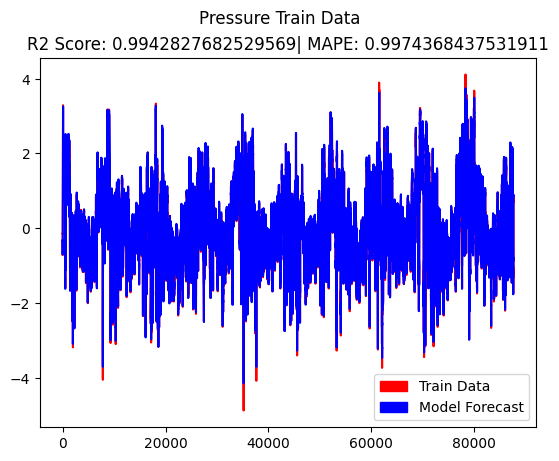

0.9942827682529569
1095/1095 [==============================] - 1s 505us/step
0.997065474171153


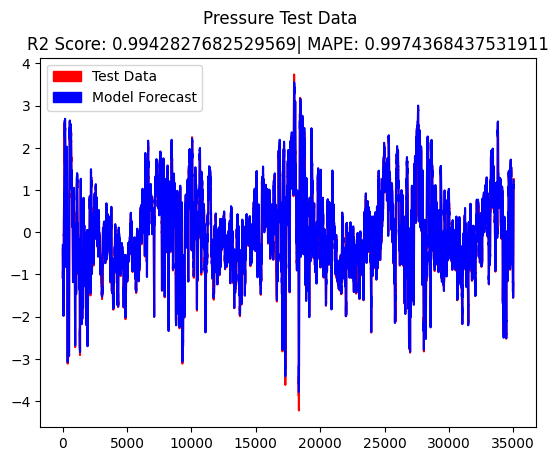

0.9934795825265339


In [12]:
predictionpres = model.predict(pressure_train)
pressure_trainF = pressure_trainF.reshape(pressure_trainF.size, 1)
predictionpres = predictionpres.reshape(predictionpres.size, 1)

overall = pd.concat([pd.DataFrame(pressure_trainF), pd.DataFrame(predictionpres)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, predictionpres.shape[0], predictionpres.shape[0]), pressure_trainF, color="r")
plt.plot(np.linspace(0,predictionpres.shape[0], predictionpres.shape[0]), predictionpres, color="b")
title5 = "R2 Score: "+str(r2_score(pressure_trainF, predictionpres))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Pressure Train Data")
plt.title(title5)
red_patch = mpatches.Patch(color='red', label='Train Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

print(r2_score(pressure_trainF, predictionpres))

predictionpres2 = model.predict(pressure_test)
pressure_testF = pressure_testF.reshape(pressure_testF.size, 1)
predictionpres2 = predictionpres2.reshape(predictionpres2.size, 1)

overall = pd.concat([pd.DataFrame(pressure_testF), pd.DataFrame(predictionpres2)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, predictionpres2.shape[0], predictionpres2.shape[0]), pressure_testF, color="r")
plt.plot(np.linspace(0,predictionpres2.shape[0], predictionpres2.shape[0]), predictionpres2, color="b")
title6 = "R2 Score: "+str(r2_score(pressure_testF, predictionpres2))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Pressure Test Data")
plt.title(title5)
red_patch = mpatches.Patch(color='red', label='Test Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

print(r2_score(pressure_testF, predictionpres2))

#5- HUMIDITY TIME SERIES

In [13]:
humidity_train, humidity_trainF = create_dataset(humidity_train, look_back=24)
humidity_test, humidity_testF = create_dataset(humidity_test, look_back=24)
humidity_trainF = humidity_trainF.reshape(humidity_trainF.size, 1)
humidity_testF = humidity_testF.reshape(humidity_testF.size, 1)

humidity_train = np.reshape(humidity_train, (humidity_train.shape[0], 1, humidity_train.shape[1]))
humidity_trainF = np.reshape(humidity_trainF, (humidity_trainF.shape[0], 1, humidity_trainF.shape[1]))

humidity_test = np.reshape(humidity_test, (humidity_test.shape[0], 1, humidity_test.shape[1]))
humidity_testF = np.reshape(humidity_testF, (humidity_testF.shape[0], 1, humidity_testF.shape[1]))

model = keras.Sequential()
model.add(LSTM(64, activation="sigmoid", return_sequences=True, input_shape=(1,24)))
model.add(Bidirectional(LSTM(64, activation="sigmoid",  return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation="sigmoid",  return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
model.fit(humidity_train, humidity_trainF, epochs=5, batch_size=24, verbose=2)

Epoch 1/5
3652/3652 - 7s - loss: 0.0911 - mae: 0.1970 - mape: 66.6194 - 7s/epoch - 2ms/step
Epoch 2/5
3652/3652 - 6s - loss: 0.0437 - mae: 0.1460 - mape: 54.6455 - 6s/epoch - 2ms/step
Epoch 3/5
3652/3652 - 6s - loss: 0.0424 - mae: 0.1427 - mape: 53.4988 - 6s/epoch - 2ms/step
Epoch 4/5
3652/3652 - 6s - loss: 0.0418 - mae: 0.1414 - mape: 52.9137 - 6s/epoch - 2ms/step
Epoch 5/5
3652/3652 - 6s - loss: 0.0415 - mae: 0.1407 - mape: 52.5912 - 6s/epoch - 2ms/step


2739/2739 [==============================] - 2s 516us/step
0.9800808427513732


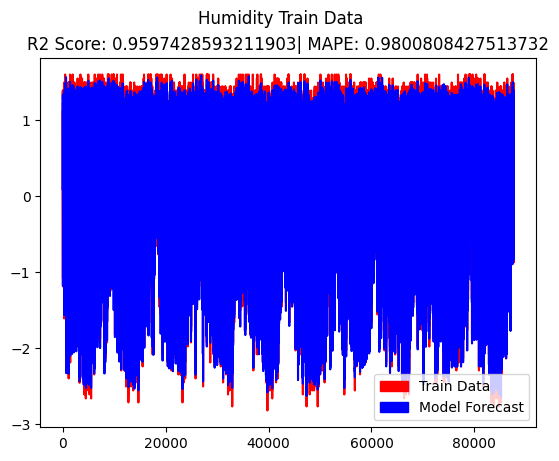

0.9597428593211903
1095/1095 [==============================] - 1s 535us/step
0.9802081540505098


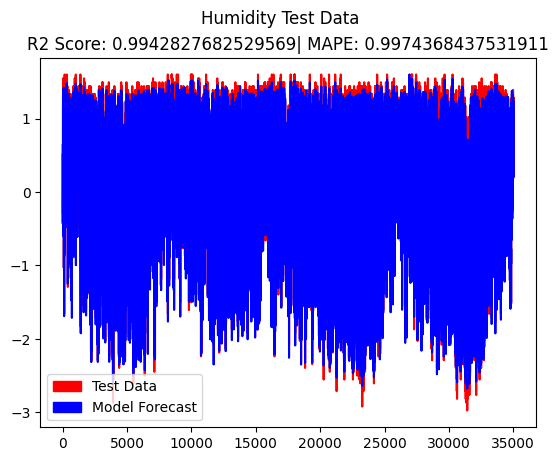

0.9599430685420147


In [14]:
predictionhum = model.predict(humidity_train)
humidity_trainF = humidity_trainF.reshape(humidity_trainF.size, 1)
predictionhum = predictionhum.reshape(predictionhum.size, 1)

overall = pd.concat([pd.DataFrame(humidity_trainF), pd.DataFrame(predictionhum)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, predictionhum.shape[0], predictionhum.shape[0]), humidity_trainF, color="r")
plt.plot(np.linspace(0,predictionhum.shape[0], predictionhum.shape[0]), predictionhum, color="b")
title7 = "R2 Score: "+str(r2_score(humidity_trainF, predictionhum))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Humidity Train Data")
plt.title(title7)
red_patch = mpatches.Patch(color='red', label='Train Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

print(r2_score(humidity_trainF, predictionhum))

predictionhum2 = model.predict(humidity_test)
humidity_testF = humidity_testF.reshape(humidity_testF.size, 1)
predictionhum2 = predictionhum2.reshape(predictionhum2.size, 1)

overall = pd.concat([pd.DataFrame(humidity_testF), pd.DataFrame(predictionhum2)],axis=1)
overall.columns= ["Prediction", "Wind"]
print(overall["Prediction"].corr(overall["Wind"]))

plt.plot(np.linspace(0, predictionhum2.shape[0], predictionhum2.shape[0]), humidity_testF, color="r")
plt.plot(np.linspace(0,predictionhum2.shape[0], predictionhum2.shape[0]), predictionhum2, color="b")
title8 = "R2 Score: "+str(r2_score(humidity_testF, predictionhum2))+"| MAPE: "+str(overall["Prediction"].corr(overall["Wind"]))
plt.suptitle("Humidity Test Data")
plt.title(title5)
red_patch = mpatches.Patch(color='red', label='Test Data')
blue_patch = mpatches.Patch(color='blue', label='Model Forecast')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

print(r2_score(humidity_testF, predictionhum2))

#6- ARIMA

In [15]:
past_wind = wind_speed_orj[:3653*24]
forecast_wind = wind_speed_orj[3653*24:]
AR1 = 1.195666
AR2 = -0.73252
AR3 = -0.22058
AR4 = -0.25192
MA = 0.999921
arima_prediction_train = (past_wind[:-4]*AR1+past_wind[1:-3]*AR2+past_wind[2:-2]*AR3+past_wind[3:-1]*AR4+MA*(past_wind[1:-3]+past_wind[2:-2]+past_wind[3:-1])/3)
arima_prediction_test =  (forecast_wind[:-4]*AR1+forecast_wind[1:-3]*AR2+forecast_wind[2:-2]*AR3+forecast_wind[3:-1]*AR4+MA*(forecast_wind[1:-3]+forecast_wind[2:-2]+forecast_wind[3:-1])/3)

In [16]:
arima_prediction_train_upp = arima_prediction_train + np.std(arima_prediction_train[:24])*1.88
arima_prediction_train_low = arima_prediction_train - np.std(arima_prediction_train[:24])*1.88

0.9554932019344831
0.9608066862538153


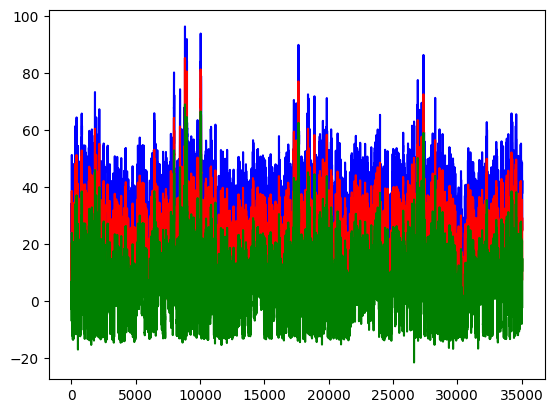

In [17]:
#plt.plot(forecast_wind[4:], color="r")
#plt.plot(arima_prediction_test, color="b")

a = 3653*24
#n = 3653*24
#plt.plot(arima_prediction_train_upp[n-a:n], color="b")
#plt.plot(arima_prediction_train[n-a:n], color="black")
#plt.plot(past_wind[n+4-a:n+4], color="r")
#plt.plot(arima_prediction_train_low[n-a:n], color="g")

high_barrier = past_wind[4:] <= arima_prediction_train_upp
low_barrier = past_wind[4:] >= arima_prediction_train_low

print(np.sum(high_barrier*low_barrier)/a)

arima_prediction_test_upp = arima_prediction_test + np.std(arima_prediction_train[:24])*1.88
arima_prediction_test_low = arima_prediction_test - np.std(arima_prediction_train[:24])*1.88

high_barrier = forecast_wind[4:] <= arima_prediction_test_upp
low_barrier = forecast_wind[4:] >= arima_prediction_test_low

print(np.sum(high_barrier*low_barrier)/(arima_prediction_test.shape[0]))
plt.plot(arima_prediction_test_upp, color="b")
plt.plot(forecast_wind[4:], color="r")
plt.plot(arima_prediction_test_low, color="g")


#from sklearn.metrics import r2_score, mean_absolute_percentage_error

#print(r2_score(past_wind[4:], arima_prediction_train))
#print()
#print(mean_absolute_percentage_error(past_wind[4:], arima_prediction_train))
#print("---------------")
#print(r2_score(forecast_wind[4:], arima_prediction_test))
#print(mean_absolute_percentage_error(forecast_wind[4:], arima_prediction_test))

In [18]:
1.88*np.std(past_wind)

20.945474312322826

0.8680532092981589

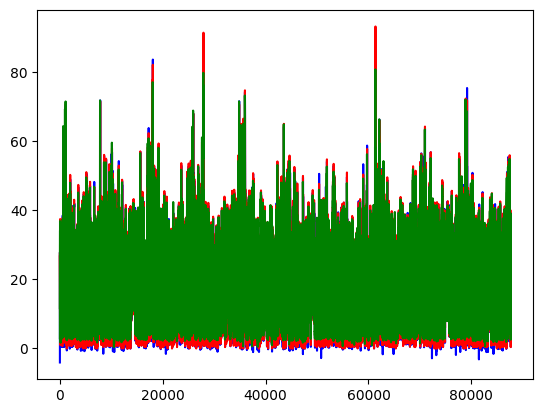

In [19]:
mean = np.mean(wind_speed_orj)
std = np.std(wind_speed_orj)

prediction_wind_training = prediction2[4:]*std+mean

n = 3653*24
plt.plot(arima_prediction_train[:n], color="b")
plt.plot(wind_speed_orj[4:n+4], color="r")
plt.plot(prediction_wind_training[:n], color="g")

r2_score(wind_speed_orj[24+5:3653*24], prediction_wind_training)

#7 - WIND ENERGY FORMULA

In [20]:
def wind_energy(wind_speed, temperature, humidity, pressure, swept_area=200, performance=50): #displays in kWh
  first_coef = 1/2*swept_area
  second_coef = (wind_speed*5/18)**3
  kelvin = temperature + 273.15
  p1 = 10**((7.5*temperature)/(temperature+237.3))
  p1 = p1*6.1078
  pv = p1*humidity
  pd = pressure - pv
  air_density = (pd/(287.058*kelvin) + pv/(461.495*kelvin))
  wind_power = first_coef*second_coef*air_density
  wind_energy = performance*wind_power
  return wind_energy/(100000)

0.8765376855168563
0.991374490855363


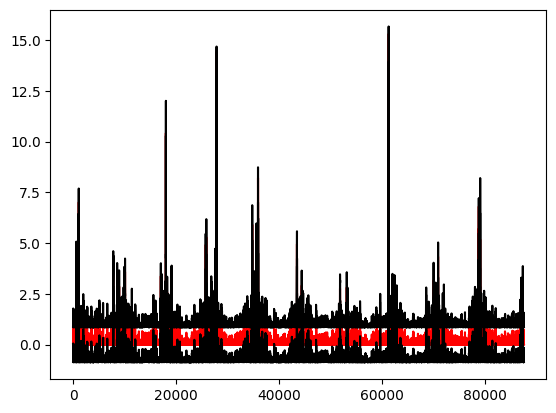

In [21]:
wind_speed_LSTM = prediction2*np.std(wind_speed_orj) + np.mean(wind_speed_orj)
temperature_LSTM = predictiontemp*np.std(temperature_orj) + np.mean(temperature_orj)
humidity_LSTM = predictionhum*np.std(humidity_orj) + np.mean(humidity_orj)
pressure_LSTM = predictionpres*np.std(pressure_orj) + np.mean(pressure_orj)


LSTM_wind_energy_predictions = wind_energy(wind_speed_LSTM, temperature_LSTM, humidity_LSTM, pressure_LSTM, swept_area=314, performance=50)
ARIMA_wind_energy_predictions = wind_energy(arima_prediction_train[21:], temperature_LSTM, humidity_LSTM, pressure_LSTM, swept_area=314, performance=50)
train_wind_energy_calculations = wind_energy(wind_speed_orj[:3653*24], temperature_orj[:3653*24], humidity_orj[:3653*24], pressure_orj[:3653*24], swept_area=314, performance=50)

n = 1 #DAY NUMBER

ARIMA_upper_bound_predictions = ARIMA_wind_energy_predictions + np.std(ARIMA_wind_energy_predictions)*1.88
ARIMA_lower_bound_predictions = ARIMA_wind_energy_predictions - np.std(ARIMA_wind_energy_predictions)*1.88


plt.plot(train_wind_energy_calculations[24:], color="r")
#plt.plot(LSTM_wind_energy_predictions, color="b")
plt.plot(ARIMA_upper_bound_predictions, color="black")
plt.plot(ARIMA_lower_bound_predictions, color="black")

#R2 SCORE OF LSTM MODEL IN TERMS OF ENERGY
print(r2_score(train_wind_energy_calculations[25:], LSTM_wind_energy_predictions))

#SUCCESS OF UPPER AND LOWER BOUNDS IN KEEPING THE REAL VALUE IN BETWEEN
upper_bound_quest = ARIMA_upper_bound_predictions > train_wind_energy_calculations[25:]
lower_bound_quest = ARIMA_lower_bound_predictions < train_wind_energy_calculations[25:]
print(np.sum(upper_bound_quest*lower_bound_quest)/(upper_bound_quest.shape[0]))

0.8759210035598175
0.9896677702934125
[4.08055095]


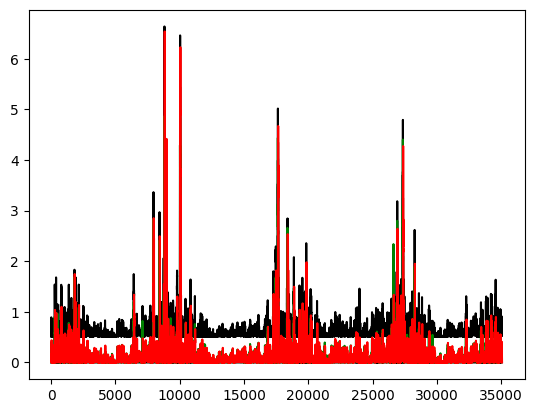

In [22]:
wind_speed_LSTM2 = prediction3*np.std(wind_speed_orj) + np.mean(wind_speed_orj)
temperature_LSTM2 = predictiontemp2*np.std(temperature_orj) + np.mean(temperature_orj)
humidity_LSTM2 = predictionhum2*np.std(humidity_orj) + np.mean(humidity_orj)
pressure_LSTM2 = predictionpres2*np.std(pressure_orj) + np.mean(pressure_orj)


LSTM_wind_energy_predictions2 = wind_energy(wind_speed_LSTM2, temperature_LSTM2, humidity_LSTM2, pressure_LSTM2)
ARIMA_wind_energy_predictions2 = wind_energy(arima_prediction_test[21:], temperature_LSTM2, humidity_LSTM2, pressure_LSTM2)
test_wind_energy_calculations = wind_energy(wind_speed_orj[3653*24:], temperature_orj[3653*24:], humidity_orj[3653*24:], pressure_orj[3653*24:])

ARIMA_upper_bound_predictions2 = ARIMA_wind_energy_predictions2 + np.std(ARIMA_wind_energy_predictions2)*1.88
ARIMA_lower_bound_predictions2 = ARIMA_wind_energy_predictions2 - np.std(ARIMA_wind_energy_predictions2)*1.88
ARIMA_lower_bound_predictions2[ARIMA_lower_bound_predictions2<0] = 0

plt.plot(ARIMA_upper_bound_predictions2, color="black")
plt.plot(ARIMA_lower_bound_predictions2, color="black")
plt.plot(LSTM_wind_energy_predictions2, color="green")
plt.plot(test_wind_energy_calculations, color="red")

print(r2_score(test_wind_energy_calculations[25:], LSTM_wind_energy_predictions2))

#SUCCESS OF UPPER AND LOWER BOUNDS IN KEEPING THE REAL VALUE IN BETWEEN
upper_bound_quest2 = ARIMA_upper_bound_predictions2 > test_wind_energy_calculations[25:]
lower_bound_quest2 = ARIMA_lower_bound_predictions2 < test_wind_energy_calculations[25:]
print(np.sum(upper_bound_quest2*lower_bound_quest2)/(upper_bound_quest2.shape[0]))
print(max(ARIMA_lower_bound_predictions2-test_wind_energy_calculations[25:]))

In [23]:
LSTM_wind_energy_predictions2.shape[0]-ARIMA_wind_energy_predictions2.shape[0]
test_wind_energy_calculations.shape[0]


i = -1
LSTM_better_upp = 0
LSTM_better_low = 0
ARIMA_better_upp = 0
ARIMA_better_low = 0
LSTM_diff_sum = 0
ARIMA_diff_sum = 0
out_of_range = 0
while i < 35035:
  i += 1
  if (LSTM_wind_energy_predictions2[i] > ARIMA_upper_bound_predictions2[i]):
    out_of_range += 1
    diff_LSTM = np.abs(LSTM_wind_energy_predictions2[i]-test_wind_energy_calculations[25+i])
    diff_ARIMA = np.abs(ARIMA_wind_energy_predictions2[i]-test_wind_energy_calculations[25+i])
    if diff_LSTM < diff_ARIMA:
      LSTM_better_upp += 1
      LSTM_diff_sum += diff_LSTM
      ARIMA_diff_sum += diff_ARIMA
    else:
      ARIMA_better_upp += 1
      LSTM_diff_sum += diff_LSTM
      ARIMA_diff_sum += diff_ARIMA
  elif (LSTM_wind_energy_predictions[i] < ARIMA_lower_bound_predictions2[i]):
    out_of_range += 1
    diff_LSTM = np.abs(LSTM_wind_energy_predictions2[i]-test_wind_energy_calculations[25+i])
    diff_ARIMA = np.abs(ARIMA_wind_energy_predictions2[i]-test_wind_energy_calculations[25+i])
    if diff_LSTM < diff_ARIMA:
      LSTM_better_low += 1
      LSTM_diff_sum += diff_LSTM
      ARIMA_diff_sum += diff_ARIMA
    else:
      ARIMA_better_low +=1
      LSTM_diff_sum += diff_LSTM
      ARIMA_diff_sum += diff_ARIMA
else:
  print(LSTM_diff_sum/out_of_range)
  print(ARIMA_diff_sum/out_of_range)

[0.25786164]
[0.43516714]


#8 - OUTPUT

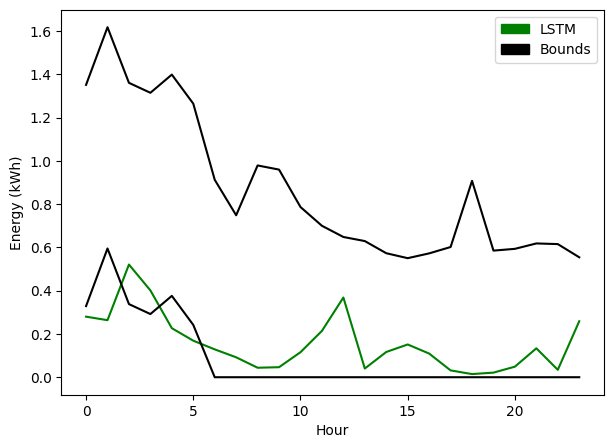

MAPE of the Last Day:  0.3083080664220728
R2 Score of the Last Day:  0.6264222980005983
Mean Risk:  0.14475028913642202


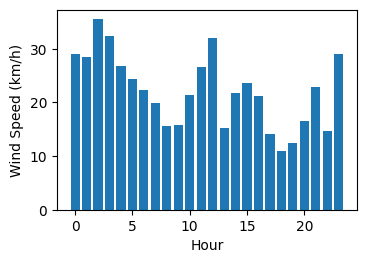

In [27]:
n = 766 #Tahminlenecek günün 2 Ocak 2019'u 0 kabul edecek şekilde gün numarası
plt.figure(figsize=(7, 5))

#24 saatlik grafik örneği (n.gün, (n+1).gün için hazırlanmış tahmin verileri)
plt.plot(LSTM_wind_energy_predictions2[24*n:24*(n+1)], color="green")
plt.plot(ARIMA_upper_bound_predictions2[24*n-4:24*(n+1)-4], color="black") #ARIMA predictions begin after 4th hour
plt.plot(ARIMA_lower_bound_predictions2[24*n-4:24*(n+1)-4], color="black")
green_patch = mpatches.Patch(color='green', label='LSTM')
black_patchs = mpatches.Patch(color='black', label='Bounds')
plt.legend(handles=[green_patch, black_patchs])
plt.ylabel("Energy (kWh)")
plt.xlabel("Hour")
plt.savefig('images/graph.png',bbox_inches='tight')
plt.show()

LSTM_output = np.array(LSTM_wind_energy_predictions2[24*n:24*(n+1)])
ARIMA_upp_output =np.array(ARIMA_upper_bound_predictions2[24*n-4:24*n+20])
ARIMA_low_output = np.array(ARIMA_lower_bound_predictions2[24*n-4:24*n+20])

#Bir önceki günün hatası
mape_last_day = np.mean(np.abs((test_wind_energy_calculations[24*n:24*n+24]-LSTM_wind_energy_predictions2[24*(n-1):24*n])/(test_wind_energy_calculations[24*n:24*n+24])))
r2_last_day = r2_score(test_wind_energy_calculations[24*n:24*(n+1)],LSTM_wind_energy_predictions2[24*(n-1):24*n])
print("MAPE of the Last Day: ", mape_last_day)
print("R2 Score of the Last Day: ", r2_last_day)

#Risk oranı verisi (ilgili günün)
ARIMA_mean = (ARIMA_upp_output + ARIMA_low_output)/2
std = np.std(ARIMA_mean)
z_score = np.abs(LSTM_output-ARIMA_mean)/std
import scipy.stats as st
mean_risk = 1-st.norm.cdf(abs(z_score))
print("Mean Risk: ", np.mean(mean_risk))

#Wind Speed Statistics (m/s)
mean_wind_speed = np.mean(wind_speed_LSTM2[24*n:24*n+24])
max_wind_speed = max(wind_speed_LSTM2[24*n:24*n+24])
min_wind_speed = min(wind_speed_LSTM2[24*n:24*n+24])

#Temperature Statistics (Celcius)
mean_temperature = np.mean(temperature_LSTM2[24*n:24*n+24])
max_temperature = max(temperature_LSTM2[24*n:24*n+24])
min_temperature = min(temperature_LSTM2[24*n:24*n+24])

#Humidity Statistics (Percentage)
mean_humidity = np.mean(humidity_LSTM2[24*n:24*n+24])
max_humidity = max(humidity_LSTM2[24*n:24*n+24])
min_humidity = min(humidity_LSTM2[24*n:24*n+24])

#Pressure Statistics
mean_pressure = np.mean(pressure_LSTM2[24*n:24*n+24])
max_pressure = max(pressure_LSTM2[24*n:24*n+24])
min_pressure = min(pressure_LSTM2[24*n:24*n+24])

#Total Energy Output (kWh)
total_energy_output = np.sum(LSTM_wind_energy_predictions2[24*n:24*n+24]) 

#Wind Speed Bar Chart
hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


fig = plt.figure(figsize=(3, 2))
ax = fig.add_axes([0,0,1,1])
ax.bar(hours, wind_speed_LSTM2[24*n:24*n+24].reshape(24))
plt.ylabel("Wind Speed (km/h)")
plt.xlabel("Hour")
plt.savefig('images/graph_bar.png',bbox_inches='tight')
plt.show()

#İndirme butonuna basıldığında aşağıdaki kod veriyi yükler:
hours = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]).reshape(24,1)
out_of_ranges = np.array((ARIMA_upp_output > LSTM_output)*(ARIMA_low_output < LSTM_output), dtype=bool)
excel_data = np.concatenate((hours, LSTM_output, ARIMA_upp_output, ARIMA_low_output, out_of_ranges),axis=1)
excel_data = pd.DataFrame(excel_data)
excel_data.columns = ["Hour", "LSTM Output", "ARIMA Upper Bound", "ARIMA Lower Bound", "In Range"]
file_name = 'Predictions.xlsx'
excel_data.to_excel(file_name)

In [28]:
#This is built to get the days who experience LSTM forecast out of ARIMA range
for i in range(365*3+1):
  n = i+1  #The day number from January 1, 2019
  if np.sum((ARIMA_lower_bound_predictions2[24*n-4:24*n+20] > LSTM_wind_energy_predictions2[n*24-4:(n+1)*24-4])) > 0:
    print("Under the lower bound: ", n)
  #if np.sum((ARIMA_upper_bound_predictions2[24*n-4:24*n+20] < LSTM_wind_energy_predictions2[24*n-4:24*(n+1)-4])) > 0:
    #print("Above the upper bound: ", n)

Under the lower bound:  16
Under the lower bound:  57
Under the lower bound:  75
Under the lower bound:  89
Under the lower bound:  321
Under the lower bound:  331
Under the lower bound:  332
Under the lower bound:  351
Under the lower bound:  364
Under the lower bound:  367
Under the lower bound:  368
Under the lower bound:  369
Under the lower bound:  372
Under the lower bound:  373
Under the lower bound:  386
Under the lower bound:  387
Under the lower bound:  395
Under the lower bound:  417
Under the lower bound:  418
Under the lower bound:  419
Under the lower bound:  420
Under the lower bound:  465
Under the lower bound:  536
Under the lower bound:  720
Under the lower bound:  734
Under the lower bound:  735
Under the lower bound:  736
Under the lower bound:  765
Under the lower bound:  766
Under the lower bound:  767
Under the lower bound:  786
Under the lower bound:  814
Under the lower bound:  821
Under the lower bound:  826
Under the lower bound:  999


#9 Dashboard

In [29]:
from tkinter import *
from tkinter.filedialog import asksaveasfilename
from PIL import ImageTk, Image, ImageDraw
from datetime import *
import time
import pandas as pd
import numpy as np 
import sys

"""mape_last_day = 0.3147963010559539
r2_last_day = 0.6099697374140711
mean_risk = 0.13992957917650853

#Wind Speed Statistics (m/s)
mean_wind_speed = 10.10
max_wind_speed = [20.23]
min_wind_speed = [30.44]

#Temperature Statistics (Celcius)
mean_temperature = 23.88
max_temperature = [66.22]
min_temperature = [4.44]

#Humidity Statistics (Percentage)
mean_humidity = 132.32
max_humidity = [23.55]
min_humidity = [05.65]

#Pressure Statistics
mean_pressure = 24
max_pressure = [4664]
min_pressure = [3664.55]"""

class Dashboard2:
    def __init__(self, window):
        self.window = window
        self.window.title("Wind Forecast Dashboard")
        self.window.geometry("1366x768")
        self.window.resizable(0, 0)
        self.window.state('zoomed')
        self.window.config(background='#eff5f6')
        # Window Icon Photo
        icon = PhotoImage(file='images/pic-icon.png')
        self.window.iconphoto(True, icon)

        # ==============================================================================
        # ================== HEADER ====================================================
        # ==============================================================================
        self.header = Frame(self.window, bg='#009df4')
        self.header.place(x=300, y=0, width=1070, height=60)

        self.logout_text = Button(self.header, text="Export as Dataframe", bg='#32cf8e', font=("", 13, "bold"), bd=0, fg='black',
                                  command = self.file_save,
                                  cursor='hand2', activebackground='#32cf8e')
        self.logout_text.pack()
        self.logout_text.place(x=880, y=15)

        # ==============================================================================
        # ================== SIDEBAR ===================================================
        # ==============================================================================
        self.sidebar = Frame(self.window, bg='#ffffff')
        self.sidebar.place(x=0, y=0, width=300, height=750)

        # =============================================================================
        # ============= BODY ==========================================================
        # =============================================================================
        self.heading = Label(self.window, text="Wind Forecast Dashboard", font=("", 15, "bold"), fg='#0064d3', bg='#eff5f6')
        self.heading.place(x=325, y=20)

        # body frame 1
        self.bodyFrame1 = Frame(self.window, bg='#ffffff')
        self.bodyFrame1.place(x=328, y=110, width=1040, height=480)

        # body frame 2
        self.bodyFrame2 = Frame(self.window, bg='#009aa5')
        self.bodyFrame2.place(x=328, y=670, width=310, height=80)

        # body frame 3
        self.bodyFrame3 = Frame(self.window, bg='#e21f26')
        self.bodyFrame3.place(x=680, y=670, width=310, height=80)

        # body frame 4
        self.bodyFrame4 = Frame(self.window, bg='#ffcb1f')
        self.bodyFrame4.place(x=1030, y=670, width=310, height=80)

        # body frame 5
        self.bodyFrame5 = Frame(self.window, bg='#ffcb1f')
        self.bodyFrame5.place(x=970, y=150, width=365, height=160)

        # ==============================================================================
        # ================== SIDEBAR ===================================================
        # ==============================================================================

        # logo
        self.logoImage = ImageTk.PhotoImage(file='images/hyy.png')
        self.logo = Label(self.sidebar, image=self.logoImage, bg='#ffffff')
        self.logo.place(x=70, y=80)

        # Name of brand/person
        self.brandName = Label(self.sidebar, text='Haluk Canpolat', bg='#000000', font=("", 15, "bold"))
        self.brandName.place(x=83, y=200)

        # Dashboard
        self.dashboardImage = ImageTk.PhotoImage(file='images/dashboard-icon.png')
        self.dashboard = Label(self.sidebar, image=self.dashboardImage, bg='#ffffff')
        self.dashboard.place(x=35, y=289)

        self.dashboard_text = Button(self.sidebar, text="Dashboard", bg='#ffffff', font=("", 13, "bold"), bd=0,
                                     cursor='hand2', activebackground='#ffffff')
        self.dashboard_text.place(x=80, y=287)

        # Manage
        self.manageImage = ImageTk.PhotoImage(file='images/manage-icon.png')
        self.manage = Label(self.sidebar, image=self.manageImage, bg='#ffffff')
        self.manage.place(x=35, y=340)

        self.manage_text = Button(self.sidebar, text="Detailed View", bg='#ffffff', font=("", 13, "bold"), bd=0,
                                  command = self.button1, cursor='hand2', activebackground='#ffffff')
        self.manage_text.pack()
        self.manage_text.place(x=80, y=345)

        # Settings
        self.settingsImage = ImageTk.PhotoImage(file='images/settings-icon.png')
        self.settings = Label(self.sidebar, image=self.settingsImage, bg='#ffffff')
        self.settings.place(x=35, y=402)

        self.settings_text = Button(self.sidebar, text="Settings", bg='#ffffff', font=("", 13, "bold"), bd=0,
                                    cursor='hand2', activebackground='#ffffff')
        self.settings_text.place(x=80, y=402)

        # Exit
        self.ExitImage = ImageTk.PhotoImage(file='images/exit-icon.png')
        self.Exit = Label(self.sidebar, image=self.ExitImage, bg='#ffffff')
        self.Exit.place(x=25, y=452)

        self.Exit_text = Button(self.sidebar, text="Exit", bg='#ffffff', font=("", 13, "bold"), bd=0,
                                cursor='hand2', activebackground='#ffffff')
        self.Exit_text.pack(pady=20)
        self.Exit_text.place(x=85, y=462)

        # =============================================================================
        # ============= BODY ==========================================================
        # =============================================================================

        # Body Frame 1
        self.pieChart_image = ImageTk.PhotoImage(file='images/pie-graph1.png')
        self.pieChart = Label(self.sidebar, image=self.pieChart_image, bg='#ffffff')
        self.pieChart.place(x=5, y=605)

        # Graph
        self.graph_image = ImageTk.PhotoImage(file='images/graph.png')
        self.graph = Label(self.bodyFrame1, image=self.graph_image, bg='#ffffff')
        self.graph.place(x=0, y=0)

        # Bar Graph
        self.graph_image_bar = ImageTk.PhotoImage(file='images/graph_bar.png')
        self.graph_bar = Label(self.bodyFrame1, image=self.graph_image_bar, bg='#ffffff')
        self.graph_bar.place(x=630, y=200)

        # Body Frame 2
        self.total_people = Label(self.bodyFrame2, text="%"+str(round(mape_last_day*100,2)), bg='#009aa5', font=("", 25, "bold"))
        self.total_people.place(x=90, y=30)

        # Body Frame Extras
        self.meann = Label(self.bodyFrame1, text="Mean", bg='#e21f26', wraplength=1, font=("", 8, "bold"))
        self.meann.place(x=620, y=45)
        self.minn = Label(self.bodyFrame1, text="Max", bg='#e21f26', wraplength=1, font=("", 8, "bold"))
        self.minn.place(x=620, y=100)
        self.maxx = Label(self.bodyFrame1, text="Min", bg='#e21f26', wraplength=1, font=("", 8, "bold"))
        self.maxx.place(x=620, y=151)

        self.windd = Label(self.bodyFrame1, text="Wind", bg='#e21f26', font=("", 15, "bold"))
        self.windd.place(x=650, y=10)

        self.tempp = Label(self.bodyFrame1, text="Temp", bg='#e21f26', font=("", 15, "bold"))
        self.tempp.place(x=730, y=10)

        self.humm = Label(self.bodyFrame1, text="Humidity", bg='#e21f26', font=("", 15, "bold"))
        self.humm.place(x=810, y=10)

        self.pree = Label(self.bodyFrame1, text="Pressure", bg='#e21f26', font=("", 15, "bold"))
        self.pree.place(x=900, y=10)

        self.mean_wind = Label(self.bodyFrame5, text=round(mean_wind_speed,1), bg='#009aa5', font=("", 25, "bold"))
        self.mean_wind.place(x=10, y=10)
        self.max_wind = Label(self.bodyFrame5, text=round(max_wind_speed[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.max_wind.place(x=10, y=60)
        self.min_wind = Label(self.bodyFrame5, text=round(min_wind_speed[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.min_wind.place(x=10, y=110)

        self.mean_temp = Label(self.bodyFrame5, text=round(mean_temperature,1), bg='#009aa5', font=("", 25, "bold"))
        self.mean_temp.place(x=90, y=10)
        self.max_temp = Label(self.bodyFrame5, text=round(max_temperature[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.max_temp.place(x=90, y=60)
        self.min_temp = Label(self.bodyFrame5, text=round(min_temperature[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.min_temp.place(x=90, y=110)

        self.mean_hum = Label(self.bodyFrame5, text=round(mean_humidity,1), bg='#009aa5', font=("", 25, "bold"))
        self.mean_hum.place(x=170, y=10)
        self.max_hum = Label(self.bodyFrame5, text=round(max_humidity[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.max_hum.place(x=170, y=60)
        self.min_hum = Label(self.bodyFrame5, text=round(min_humidity[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.min_hum.place(x=170, y=110)

        self.mean_pre = Label(self.bodyFrame5, text=round(mean_pressure,1), bg='#009aa5', font=("", 25, "bold"))
        self.mean_pre.place(x=260, y=10)
        self.max_pre = Label(self.bodyFrame5, text=round(max_pressure[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.max_pre.place(x=260, y=60)
        self.min_pre = Label(self.bodyFrame5, text=round(min_pressure[0],1), bg='#009aa5', font=("", 25, "bold"))
        self.min_pre.place(x=260, y=110)

        self.totalPeopleImage = ImageTk.PhotoImage(file='images/left-icon.png')
        self.totalPeople = Label(self.bodyFrame2, image=self.totalPeopleImage, bg='#009aa5')
        self.totalPeople.place(x=220, y=0)

        self.totalPeople_label = Label(self.bodyFrame2, text="MAPE of the Last Day", bg='#009aa5', font=("", 12, "bold"),
                                       fg='white')
        self.totalPeople_label.place(x=5, y=5)

        # Body Frame 3
        self.people_left = Label(self.bodyFrame3, text=round(r2_last_day,2), bg='#e21f26', font=("", 25, "bold"))
        self.people_left.place(x=120, y=30)

        # left icon
        self.LeftImage = ImageTk.PhotoImage(file='images/left-icon.png')
        self.Left = Label(self.bodyFrame3, image=self.LeftImage, bg='#e21f26')
        self.Left.place(x=220, y=0)

        self.peopleLeft_label = Label(self.bodyFrame3, text="R2 Score of the Last Day", bg='#e21f26', font=("", 12, "bold"),
                                      fg='white')
        self.peopleLeft_label.place(x=5, y=5)

        # Body Frame 4
        self.total_earnings = Label(self.bodyFrame4, text= "%" + str(round(np.mean(mean_risk)*100,2)), bg='#ffcb1f', font=("", 25, "bold"))
        self.total_earnings.place(x=80, y=30)

        self.earnings_label = Label(self.bodyFrame4, text="Mean Risk", bg='#ffcb1f', font=("", 12, "bold"),
                                    fg='white')
        self.earnings_label.place(x=5, y=5)
        # Frame 4 icon
        self.earningsIcon_image = ImageTk.PhotoImage(file='images/earn3.png')
        self.earningsIcon = Label(self.bodyFrame4, image=self.earningsIcon_image, bg='#ffcb1f')
        self.earningsIcon.place(x=220, y=0)




        # date and Time
        self.clock_image = ImageTk.PhotoImage(file="images/time.png")
        self.date_time_image = Label(self.sidebar, image=self.clock_image, bg="white")
        self.date_time_image.place(x=88, y=20)

        self.date_time = Label(self.window)
        self.date_time.place(x=115, y=15)
        self.show_time()

    def show_time(self):
        self.time = time.strftime("%H:%M:%S")
        self.date = time.strftime('%Y/%m/%d')
        set_text = f"  {self.time} \n {self.date}"
        self.date_time.configure(text=set_text, font=("", 13, "bold"), bd=0, bg="white", fg="black")
        self.date_time.after(100, self.show_time)

    def file_save(self):
        fname = asksaveasfilename(filetypes=(("Excel files", "*.xlsx"),
                                        ("All files", "*.*")))
        # note: this will fail unless user ends the fname with ".xlsx"
        excel_data.to_excel(fname)


    def button1(self):
        r = Toplevel()
        r.title("Detailed View")
        r.geometry("787x607")
        r.resizable(0, 0)
        r.state('zoomed')
        r.config(background='#eff5f6')
        canvas = Frame(r, bg='#009df4')
        canvas.place(x=0, y=0, width=787, height=607)
        my_image = ImageTk.PhotoImage(file='images/graph_det.png')
        manage = Label(canvas, image=my_image, bg='#ffffff')
        manage.place(x=0, y=0)
        r.mainloop()

def wind():
    window = Tk()
    Dashboard2(window)
    window.mainloop()


if __name__ == '__main__':
    wind()